In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
import matplotlib
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
# load imagenet class names for visualization usage
class_name_txt = 'imagenet1000_clsid_to_human.txt'
lines = open(class_name_txt).readlines()
class_map, inverse_class_map = {}, {}
for line in lines:
    line_split = line.strip().strip(',').strip("'").split(": '")
    class_id = int(line_split[0])
    class_name = line_split[1]
    class_map[class_id] = class_name
    inverse_class_map[class_name] = class_id

In [49]:
# Load the pretrained model
# pretrained_model = models.resnet18(pretrained=True)
pretrained_model = models.vgg11(pretrained=True)
# Set model to evaluation mode
pretrained_model.eval()
pretrained_model = pretrained_model.to(device)

In [50]:
# scaler = transforms.Scale((224, 224))
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

340 zebra


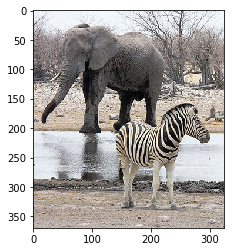

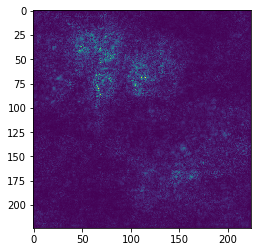

In [61]:
image_name = 'images/elephant_zebra_1.jpg'
img = Image.open(image_name)
t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
t_img = t_img.to(device)
t_img.requires_grad = True
output = pretrained_model(t_img)
_, label = torch.max(output, 1)
plt.subplots(1)
plt.imshow(img)
label = label.cpu().numpy()[0]
print(label, class_map[label])
output[0, label].backward()
image_grad = t_img.grad.squeeze(0).permute(1, 2, 0)
gradient_map = torch.abs(image_grad).cpu().numpy()
gradient_map = np.max(gradient_map, 2)
gradient_map = gradient_map / np.max(gradient_map)
plt.subplots(1)
plt.imshow(gradient_map)
plt.show()

In [62]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    def __init__(self, features, num_classes=1000):
        super(VGG, self).__init__()
        classifiers = [
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        ]
        self.layers = nn.ModuleList(features + classifiers)
        self.reshape_feature_layer_num = len(features)

    def forward(self, x):
        layer_sizes = []
        for i, layer in list(enumerate(self.layers)):
            layer_sizes.append(x.size())
            if i == self.reshape_feature_layer_num:
                x = x.view(x.size(0), -1)
            x = layer(x)
        return x, layer_sizes

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return layers


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")
    """
    model = VGG(make_layers(cfg['A']), **kwargs)
    return model


def vgg11_bn(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    """
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    return model


def vgg13(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B")
    """
    model = VGG(make_layers(cfg['B']), **kwargs)
    return model


def vgg13_bn(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    """
    model = VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)
    return model


def vgg16(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")
    """
    model = VGG(make_layers(cfg['D']), **kwargs)
    return model


def vgg16_bn(**kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    """
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    return model


def vgg19(**kwargs):
    """VGG 19-layer model (configuration "E")
    """
    model = VGG(make_layers(cfg['E']), **kwargs)
    return model


def vgg19_bn(**kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    """
    model = VGG(make_layers(cfg['E'], batch_norm=True), **kwargs)
    return model

In [63]:
new_model = vgg11()
new_model.eval()
new_model = new_model.to(device)

In [64]:
pretrained_layers = list(pretrained_model.state_dict().items())
count=0
for key, value in new_model.state_dict().items():
    layer_name, weights = pretrained_layers[count]
    new_model.state_dict()[key].data.copy_(weights)
    count+=1

340 zebra


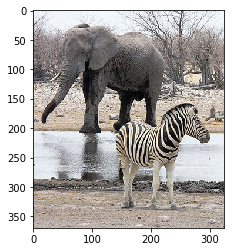

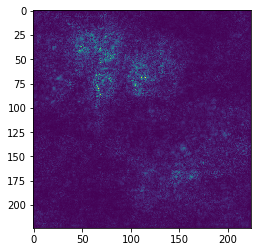

[torch.Size([1, 3, 224, 224]), torch.Size([1, 64, 224, 224]), torch.Size([1, 64, 224, 224]), torch.Size([1, 64, 112, 112]), torch.Size([1, 128, 112, 112]), torch.Size([1, 128, 112, 112]), torch.Size([1, 128, 56, 56]), torch.Size([1, 256, 56, 56]), torch.Size([1, 256, 56, 56]), torch.Size([1, 256, 56, 56]), torch.Size([1, 256, 56, 56]), torch.Size([1, 256, 28, 28]), torch.Size([1, 512, 28, 28]), torch.Size([1, 512, 28, 28]), torch.Size([1, 512, 28, 28]), torch.Size([1, 512, 28, 28]), torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 7, 7]), torch.Size([1, 4096]), torch.Size([1, 4096]), torch.Size([1, 4096]), torch.Size([1, 4096]), torch.Size([1, 4096]), torch.Size([1, 4096])]


In [65]:
image_name = 'images/elephant_zebra_1.jpg'
img = Image.open(image_name)
t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
t_img = t_img.to(device)
t_img.requires_grad = True
output, layer_sizes = new_model(t_img)
_, label = torch.max(output, 1)
plt.subplots(1)
plt.imshow(img)
label = label.cpu().numpy()[0]
print(label, class_map[label])
output[0, label].backward()
image_grad = t_img.grad.squeeze(0).permute(1, 2, 0)
gradient_map = torch.abs(image_grad).cpu().numpy()
gradient_map = np.max(gradient_map, 2)
gradient_map = gradient_map / np.max(gradient_map)
plt.subplots(1)
plt.imshow(gradient_map)
plt.show()
print(layer_sizes)

In [73]:
__all__ = [
    'VGG_FB', 'vgg11_fb', 'vgg11_fb_bn', 'vgg13_fb', 'vgg13_fb_bn', 'vgg16_fb', 'vgg16_fb_bn',
    'vgg19_fb_bn', 'vgg19_fb',
]


class VGG_FB(nn.Module):
    def __init__(self, features, layer_sizes, num_classes=1000):
        super(VGG_FB, self).__init__()
        classifiers = [
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=False),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=False),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        ]
        self.layers = nn.ModuleList(features + classifiers)
        self.reshape_feature_layer_num = len(features)
        self.layer_sizes = layer_sizes
        # Add hidden gates for selective layers such as ReLU and Max-pooling
        self.z = {}
        for i, layer in list(enumerate(self.layers)):
            # if isinstance(layer, nn.ReLU):
            #     self.z[i] = torch.ones(layer_sizes[i])
            # elif isinstance(layer, nn.MaxPool2d):
            #     self.z[i] = torch.ones(layer_sizes[i])
            self.z[i] = torch.ones(self.layer_sizes[i]).to(device)
    
    def reset(self):
        for i in self.z.keys():
            self.z[i] = torch.ones(self.layer_sizes[i]).to(device)
    
    def forward(self, x):
        self.input = []
        self.output = []
        for i, layer in list(enumerate(self.layers)):
            # detach from previous history
            x = Variable(x.data, requires_grad=True)
            self.input.append(x)
            if i in self.z:
                # multiply by the hidden gate
                x = x * self.z[i]
            if i == self.reshape_feature_layer_num:
                x = x.view(x.size(0), -1)
            # compute output
            x = layer(x)
            # add to list of outputs
            self.output.append(x)
        return x
    
    def backward(self, g):
        for i, output in reversed(list(enumerate(self.output))):
            if i == (len(self.output) - 1):
                # for last node, use g
                output.backward(g)
            else:
                output.backward(self.input[i+1].grad.data)
            if i in self.z:
                alpha = self.input[i].grad
                self.z[i] = (alpha > 0).float()
                self.input[i].grad = self.z[i] * alpha
            print(i, self.input[i].grad.data.sum())
        return self.input[0].grad

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=False)]
            else:
                layers += [conv2d, nn.ReLU(inplace=False)]
            in_channels = v
    return layers


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11_fb(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")
    """
    model = VGG_FB(make_layers(cfg['A']), **kwargs)
    return model


def vgg11_fb_bn(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    """
    model = VGG_FB(make_layers(cfg['A'], batch_norm=True), **kwargs)
    return model


def vgg13_fb(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B")
    """
    model = VGG_FB(make_layers(cfg['B']), **kwargs)
    return model


def vgg13_fb_bn(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    """
    model = VGG_FB(make_layers(cfg['B'], batch_norm=True), **kwargs)
    return model


def vgg16_fb(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")
    """
    model = VGG_FB(make_layers(cfg['D']), **kwargs)
    return model


def vgg16_fb_bn(**kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    """
    model = VGG_FB(make_layers(cfg['D'], batch_norm=True), **kwargs)
    return model


def vgg19_fb(**kwargs):
    """VGG 19-layer model (configuration "E")
    """
    model = VGG_FB(make_layers(cfg['E']), **kwargs)
    return model


def vgg19_fb_bn(**kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    """
    model = VGG_FB(make_layers(cfg['E'], batch_norm=True), **kwargs)
    return model

In [74]:
feedback_model = vgg11_fb(layer_sizes=layer_sizes)
feedback_model.eval()
feedback_model = feedback_model.to(device)

In [75]:
pretrained_layers = list(pretrained_model.state_dict().items())
count=0
for key, value in feedback_model.state_dict().items():
    layer_name, weights = pretrained_layers[count]
    feedback_model.state_dict()[key].data.copy_(weights)
    count+=1

340 zebra
27 tensor(25.3062, device='cuda:0')
26 tensor(25.3062, device='cuda:0')
25 tensor(10.2183, device='cuda:0')
24 tensor(20.0382, device='cuda:0')
23 tensor(20.0382, device='cuda:0')
22 tensor(8.7405, device='cuda:0')
21 tensor(37.1727, device='cuda:0')
20 tensor(37.1727, device='cuda:0')
19 tensor(10.7830, device='cuda:0')
18 tensor(53.0057, device='cuda:0')
17 tensor(20.3765, device='cuda:0')
16 tensor(68.0056, device='cuda:0')
15 tensor(68.0056, device='cuda:0')
14 tensor(29.7851, device='cuda:0')
13 tensor(122.3407, device='cuda:0')
12 tensor(58.3114, device='cuda:0')
11 tensor(131.4356, device='cuda:0')
10 tensor(131.4356, device='cuda:0')
9 tensor(82.6248, device='cuda:0')
8 tensor(294.4703, device='cuda:0')
7 tensor(167.4607, device='cuda:0')
6 tensor(391.4113, device='cuda:0')
5 tensor(391.4113, device='cuda:0')
4 tensor(303.2060, device='cuda:0')
3 tensor(844.6483, device='cuda:0')
2 tensor(844.6480, device='cuda:0')
1 tensor(788.6061, device='cuda:0')
0 tensor(1563.606

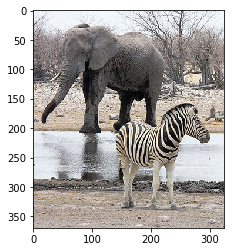

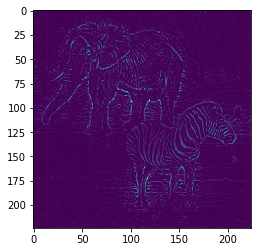

In [82]:
image_name = 'images/elephant_zebra_1.jpg'
# image_name = 'images/elephant_zebra_2.jpg'
# image_name = 'images/cat_dog_1.jpg'
# image_name = 'images/cat_dog_2.jpg'
img = Image.open(image_name)
t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
t_img = t_img.to(device)
feedback_model.reset()
output = feedback_model(t_img)
_, label = torch.max(output, 1)
plt.subplots(1)
plt.imshow(img)
label = label.cpu().numpy()[0]
print(label, class_map[label])
gradients = torch.zeros(*output.size()).to(device)
gradients[0, label] = 1.0
image_grad = feedback_model.backward(gradients)
image_grad = image_grad.squeeze(0).permute(1, 2, 0)
gradient_map = torch.abs(image_grad).cpu().numpy()
gradient_map = np.max(gradient_map, 2)
gradient_map = gradient_map / np.max(gradient_map)
plt.subplots(1)
plt.imshow(gradient_map)
plt.show()

340 zebra
27 tensor(25.3062, device='cuda:0')
26 tensor(25.3062, device='cuda:0')
25 tensor(9.9890, device='cuda:0')
24 tensor(19.9689, device='cuda:0')
23 tensor(19.9689, device='cuda:0')
22 tensor(8.4737, device='cuda:0')
21 tensor(36.8765, device='cuda:0')
20 tensor(36.8147, device='cuda:0')
19 tensor(10.6438, device='cuda:0')
18 tensor(53.2445, device='cuda:0')
17 tensor(19.7348, device='cuda:0')
16 tensor(68.0240, device='cuda:0')
15 tensor(67.6114, device='cuda:0')
14 tensor(29.2041, device='cuda:0')
13 tensor(123.2529, device='cuda:0')
12 tensor(55.9011, device='cuda:0')
11 tensor(131.6967, device='cuda:0')
10 tensor(129.9829, device='cuda:0')
9 tensor(80.2634, device='cuda:0')
8 tensor(295.6387, device='cuda:0')
7 tensor(159.7126, device='cuda:0')
6 tensor(392.7457, device='cuda:0')
5 tensor(376.4511, device='cuda:0')
4 tensor(281.1957, device='cuda:0')
3 tensor(811.7291, device='cuda:0')
2 tensor(694.4866, device='cuda:0')
1 tensor(600.3692, device='cuda:0')
0 tensor(1307.7791

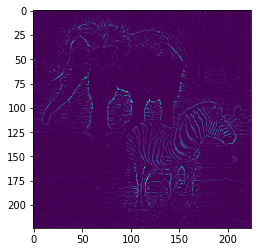

340 zebra
27 tensor(25.3062, device='cuda:0')
26 tensor(25.3062, device='cuda:0')
25 tensor(9.9714, device='cuda:0')
24 tensor(19.9573, device='cuda:0')
23 tensor(19.9573, device='cuda:0')
22 tensor(8.4628, device='cuda:0')
21 tensor(36.8768, device='cuda:0')
20 tensor(36.7989, device='cuda:0')
19 tensor(10.6251, device='cuda:0')
18 tensor(53.2553, device='cuda:0')
17 tensor(19.6663, device='cuda:0')
16 tensor(67.9811, device='cuda:0')
15 tensor(67.5371, device='cuda:0')
14 tensor(29.1343, device='cuda:0')
13 tensor(123.1553, device='cuda:0')
12 tensor(55.4634, device='cuda:0')
11 tensor(131.2293, device='cuda:0')
10 tensor(129.2932, device='cuda:0')
9 tensor(79.6444, device='cuda:0')
8 tensor(294.5435, device='cuda:0')
7 tensor(157.4988, device='cuda:0')
6 tensor(389.8770, device='cuda:0')
5 tensor(369.2922, device='cuda:0')
4 tensor(272.7645, device='cuda:0')
3 tensor(789.8700, device='cuda:0')
2 tensor(671.3873, device='cuda:0')
1 tensor(578.0547, device='cuda:0')
0 tensor(1280.1301

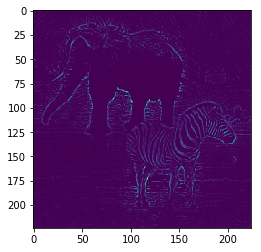

340 zebra
27 tensor(25.3062, device='cuda:0')
26 tensor(25.3062, device='cuda:0')
25 tensor(9.9714, device='cuda:0')
24 tensor(19.9573, device='cuda:0')
23 tensor(19.9573, device='cuda:0')
22 tensor(8.4628, device='cuda:0')
21 tensor(36.8768, device='cuda:0')
20 tensor(36.7934, device='cuda:0')
19 tensor(10.6195, device='cuda:0')
18 tensor(53.2515, device='cuda:0')
17 tensor(19.6623, device='cuda:0')
16 tensor(67.9802, device='cuda:0')
15 tensor(67.5210, device='cuda:0')
14 tensor(29.1192, device='cuda:0')
13 tensor(123.1482, device='cuda:0')
12 tensor(55.3823, device='cuda:0')
11 tensor(131.1319, device='cuda:0')
10 tensor(129.1580, device='cuda:0')
9 tensor(79.5279, device='cuda:0')
8 tensor(294.3074, device='cuda:0')
7 tensor(156.9618, device='cuda:0')
6 tensor(389.1566, device='cuda:0')
5 tensor(367.6246, device='cuda:0')
4 tensor(270.8863, device='cuda:0')
3 tensor(785.1599, device='cuda:0')
2 tensor(667.2504, device='cuda:0')
1 tensor(574.4951, device='cuda:0')
0 tensor(1276.8577

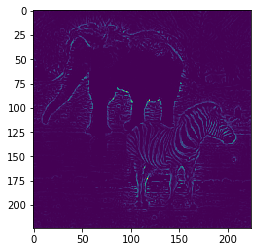

In [83]:
for iter in range(3):
    output = feedback_model(t_img)
    _, label = torch.max(output, 1)
    label = label.cpu().numpy()[0]
    print(label, class_map[label])
    gradients = torch.zeros(*output.size()).to(device)
    gradients[0, label] = 1.0
    image_grad = feedback_model.backward(gradients)
    image_grad = image_grad.squeeze(0).permute(1, 2, 0)
    gradient_map = torch.abs(image_grad).cpu().numpy()
    gradient_map = np.max(gradient_map, 2)
    gradient_map = gradient_map / np.max(gradient_map)
    plt.subplots(1)
    plt.imshow(gradient_map)
    plt.show()